In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.metrics import confusion_matrix

In [86]:
# Reset!
os.chdir('/home/jen55/palmer_scratch/DRAGON_CNN_NEW/DRAGON_CNN/modules/')

In [87]:
label_csv = pd.read_csv("labels.csv")
label_dict = {v: k for k, v in zip(label_csv["key"], label_csv["value"])}
print(label_dict)

{0: 'rubbish', 1: 'empty_space', 2: 'single_agn', 3: 'offset_agn', 4: 'merger', 5: 'dual_agn'}


In [88]:
loss_csv = pd.read_csv("accuracy.csv")
accuracy_csv = pd.read_csv("loss.csv")

loss = loss_csv["usual-energy-1 - devel_loss"]
accuracy = accuracy_csv["usual-energy-1 - devel_accuracy"]

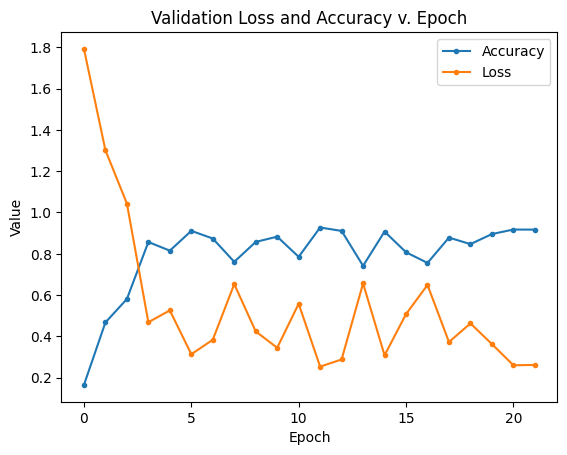

In [89]:
plt.title("Validation Loss and Accuracy v. Epoch")
x = np.arange(0, len(accuracy), 1)
plt.plot(x, accuracy, label="Accuracy", marker=".")
plt.plot(x, loss, label="Loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.show()

In [90]:
# Changing to W&B directory
os.chdir('/home/jen55/palmer_scratch/DRAGON_CNN_NEW/DRAGON_CNN/wandb')

In [91]:
def calculate_accuracies(df):
    num_classes = df["Actual"].nunique()
    
    classPreds = [0] * num_classes  # The total number of galaxies predicted as each class.
    classActual = [0] * num_classes  # The actual number of galaxies correctly predicted.
    classTotal = [0] * num_classes  # The total number of actual galaxies in each class.

    for _, row in df.iterrows():
        classTotal[row["Actual"]] += row["nPredictions"]
        classPreds[row["Predicted"]] += row["nPredictions"]
        if row["Actual"] == row["Predicted"]:
            classActual[row["Actual"]] += row["nPredictions"]

    accuracies = [0] * num_classes
    for i in range(num_classes):
        if classTotal[i] > 0:
            accuracies[i] = classActual[i] / classTotal[i]
        else:
            accuracies[i] = 0

    return accuracies

In [102]:
# Changing to desired run.
run_name = 'sjxbss6g'
for folder in os.listdir(os.getcwd()):
    if Path(folder).is_dir() and run_name in folder:
        os.chdir(folder + '/files/media/table')
        break

class_accuracies = dict()
last_df = [0, None]
for fl in Path('.').glob('*.json'):
    file_str = fl.as_posix()
    if 'devel' in file_str:
        file_num = int(file_str.split('_')[4])
        with open(fl, "r") as file:
            jsonString = file.read()
            df = pd.read_json(jsonString, orient='split')
            if file_num > last_df[0]:
                last_df = [file_num, df]
            
            class_accuracies[file_num] = calculate_accuracies(df)

class_accuracies = dict(sorted(class_accuracies.items()))
class_accuracies = list(class_accuracies.values())
per_time = list(zip(*class_accuracies))

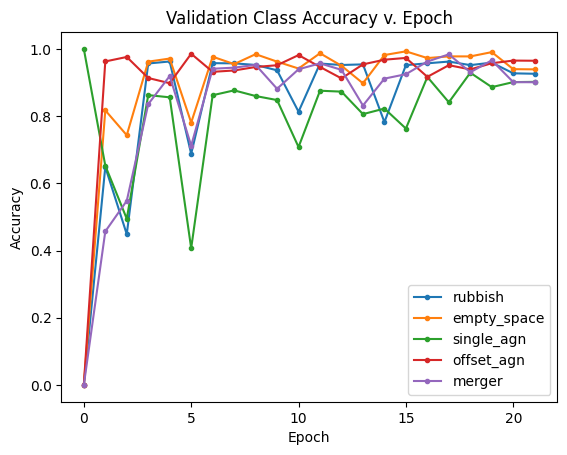

In [103]:
plt.title("Validation Class Accuracy v. Epoch")
x = np.arange(0, len(class_accuracies), 1)
for i in range(len(per_time)):
    plt.plot(x, per_time[i], label=label_dict[i], marker=".")
    
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

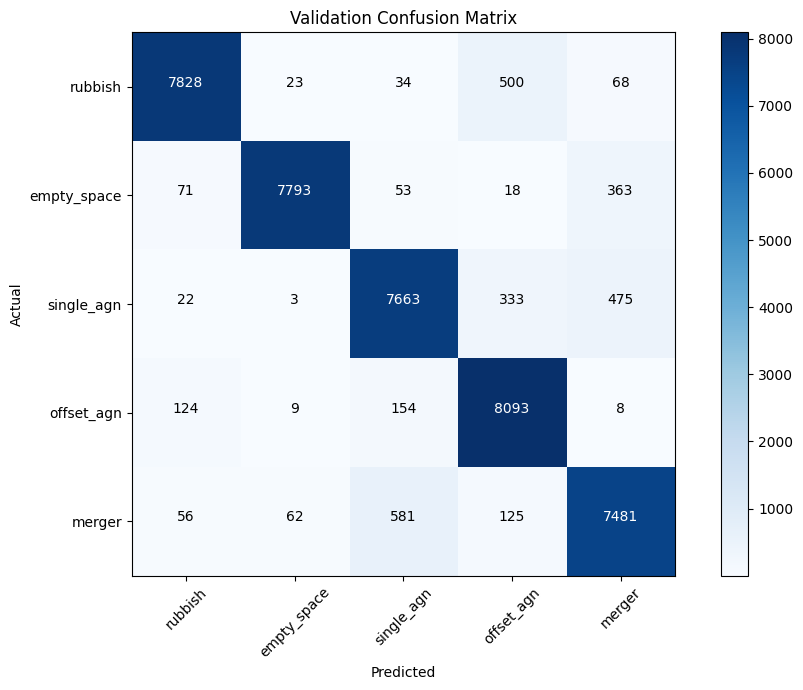

In [117]:
# Create the confusion matrix
df = last_df[1]
confusion_matrix = df.pivot(index='Actual', columns='Predicted', values='nPredictions').fillna(0)

# Map the numerical classes to their corresponding labels
actual_labels = [label_dict[i] for i in confusion_matrix.index]
predicted_labels = [label_dict[i] for i in confusion_matrix.columns]

# Plotting the confusion matrix using Matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Validation Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(confusion_matrix))
plt.xticks(tick_marks, predicted_labels, rotation=45)
plt.yticks(tick_marks, actual_labels)

# Add text annotations
thresh = confusion_matrix.values.max() / 2.
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, int(confusion_matrix.iloc[i, j]),
                 horizontalalignment="center",
                 color="white" if confusion_matrix.iloc[i, j] > thresh else "black")

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()